In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [44]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


/home/ldin/anaconda3/envs/pytorch_cuda124/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldin/anaconda3/envs/pytorch_cuda124/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/ldin/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 107MB/s]


Epoch 1: Train Loss = 1.3275, Train Acc = 0.4858, Val Loss = 1.4622, Val Acc = 0.4225
Epoch 2: Train Loss = 0.9200, Train Acc = 0.6170, Val Loss = 1.3097, Val Acc = 0.4366
Epoch 3: Train Loss = 0.7009, Train Acc = 0.7305, Val Loss = 1.1927, Val Acc = 0.5211
Epoch 4: Train Loss = 0.6113, Train Acc = 0.7837, Val Loss = 0.9932, Val Acc = 0.6479
Epoch 5: Train Loss = 0.5525, Train Acc = 0.8298, Val Loss = 1.2375, Val Acc = 0.7042
Epoch 6: Train Loss = 0.5177, Train Acc = 0.8369, Val Loss = 1.2753, Val Acc = 0.6479
Epoch 7: Train Loss = 0.4265, Train Acc = 0.8191, Val Loss = 0.9719, Val Acc = 0.5634
Epoch 8: Train Loss = 0.3435, Train Acc = 0.8865, Val Loss = 1.0730, Val Acc = 0.6479
Epoch 9: Train Loss = 0.2670, Train Acc = 0.8901, Val Loss = 0.8996, Val Acc = 0.7042
Epoch 10: Train Loss = 0.2786, Train Acc = 0.8865, Val Loss = 1.4846, Val Acc = 0.6479
Early stopping triggered. Best Validation Accuracy: 0.704225352112676


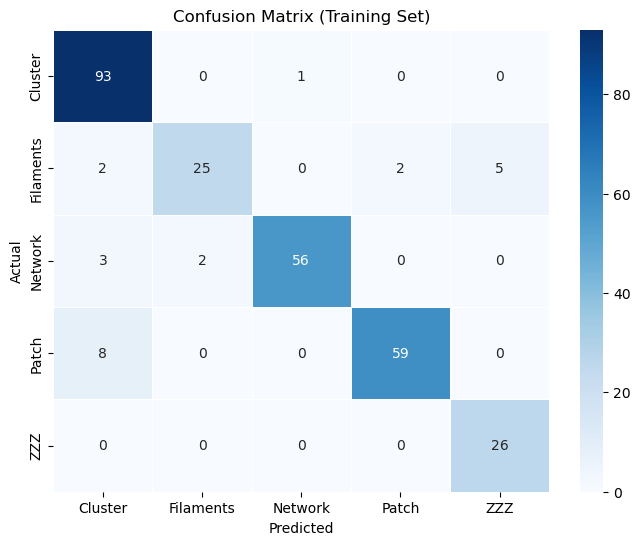

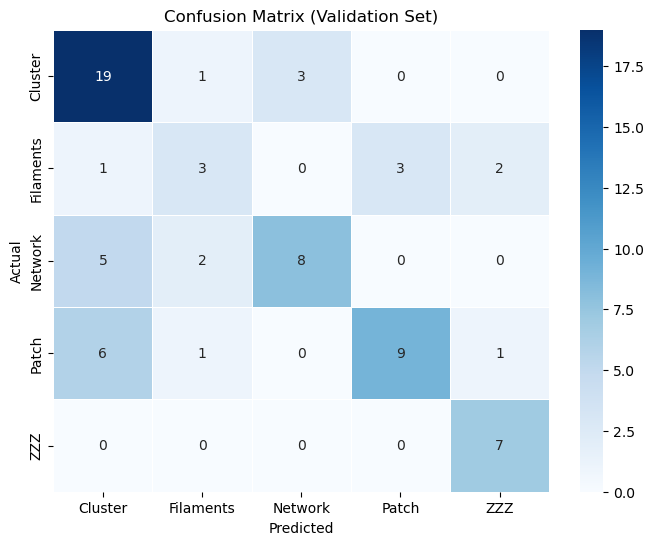

In [ ]:
# Load CSV
data_csv = "selected_for_annotation_mt_strcture_20250310_MA.csv"
image_dir = "/mnt/d/lding/CLS/mousumiLiuDinner/set1to5_processed_results/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/GUV-MT_obj_png_selected_std15"
df = pd.read_csv(data_csv)
df = df.dropna(subset=["filename", "label"])
df["label"] = df["label"].astype(str)

# Split into Train (80%) & Validation (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Define Transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe.copy()
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(self.data["label"].unique()))}
        self.data["label"] = self.data["label"].map(self.label_to_index)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Datasets & DataLoaders
train_dataset = CustomDataset(train_df, image_dir, transform=train_transform)
val_dataset = CustomDataset(val_df, image_dir, transform=val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load EfficientNet-B0 Model & Modify for Classification
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.label_to_index))
model = model.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Training Loop with Early Stopping
num_epochs = 50
best_val_acc = 0
patience = 5
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct_train / total_train
    
    # Validation Step
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_val_loss / len(val_dataloader)
    val_acc = correct_val / total_val
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Best Validation Accuracy:", best_val_acc)
            break

# Function to evaluate model
def evaluate_model(dataloader, dataset_name):
    true_labels, pred_labels = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    cm = confusion_matrix(true_labels, pred_labels)
    labels = list(train_dataset.label_to_index.keys())
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

evaluate_model(train_dataloader, "Training Set")
evaluate_model(val_dataloader, "Validation Set")



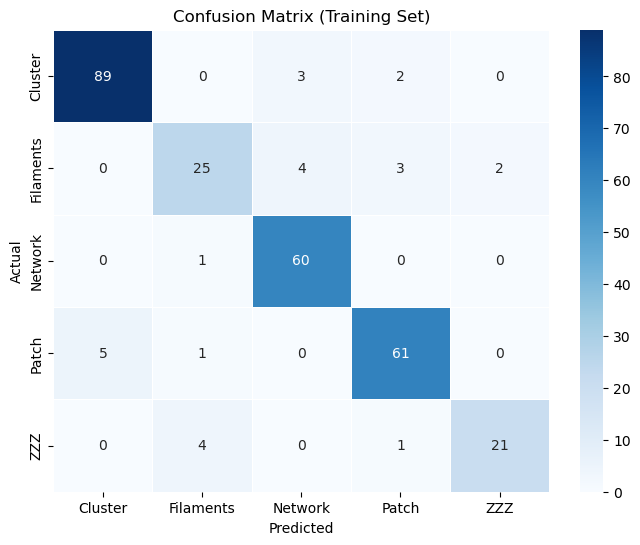

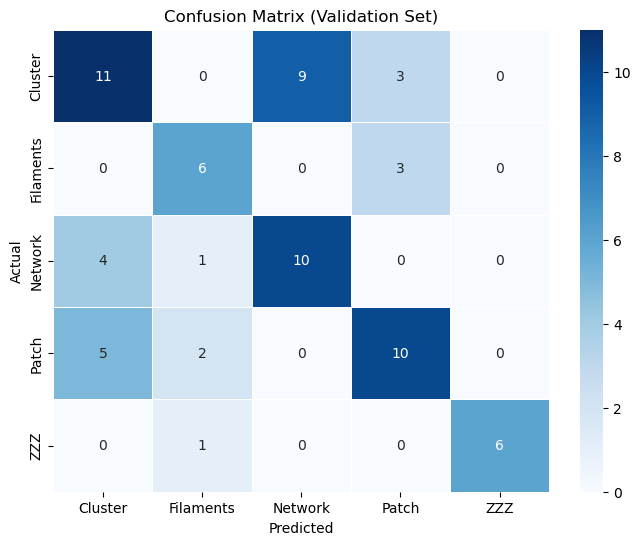

In [61]:
# Function to evaluate model
def evaluate_model(dataloader, dataset_name):
    true_labels, pred_labels = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    cm = confusion_matrix(true_labels, pred_labels)
    labels = list(train_dataset.label_to_index.keys())
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

evaluate_model(train_dataloader, "Training Set")
evaluate_model(val_dataloader, "Validation Set")

In [67]:
# Plot training and validation losses and accuracies
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

In [50]:
# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(val_loader), 100. * correct / total

In [51]:
# Training loop with loss and accuracy tracking
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float("inf")
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)
        
        val_loss, val_acc = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_acc:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")
    
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    print(f"Training completed. Best model saved as {best_model_path}")

Epoch 1/50, Loss: 1.3325, Train Acc: 48.23%, Val Acc: 45.07%
Best model saved with validation loss: 1.1815
Epoch 2/50, Loss: 1.0368, Train Acc: 62.41%, Val Acc: 60.56%
Epoch 3/50, Loss: 0.7072, Train Acc: 74.11%, Val Acc: 23.94%
Epoch 4/50, Loss: 0.6377, Train Acc: 75.53%, Val Acc: 39.44%
Epoch 5/50, Loss: 0.4536, Train Acc: 82.98%, Val Acc: 43.66%
Epoch 6/50, Loss: 0.4126, Train Acc: 81.91%, Val Acc: 59.15%
Epoch 7/50, Loss: 0.3836, Train Acc: 84.75%, Val Acc: 56.34%
Epoch 8/50, Loss: 0.3959, Train Acc: 86.17%, Val Acc: 59.15%
Epoch 9/50, Loss: 0.2055, Train Acc: 93.26%, Val Acc: 52.11%
Epoch 10/50, Loss: 0.2311, Train Acc: 91.84%, Val Acc: 53.52%
Epoch 11/50, Loss: 0.1797, Train Acc: 92.91%, Val Acc: 56.34%
Epoch 12/50, Loss: 0.1262, Train Acc: 96.10%, Val Acc: 64.79%
Epoch 13/50, Loss: 0.1379, Train Acc: 96.10%, Val Acc: 59.15%
Epoch 14/50, Loss: 0.0994, Train Acc: 98.58%, Val Acc: 52.11%
Best model saved with validation loss: 1.1401
Epoch 15/50, Loss: 0.1436, Train Acc: 96.45%, Val

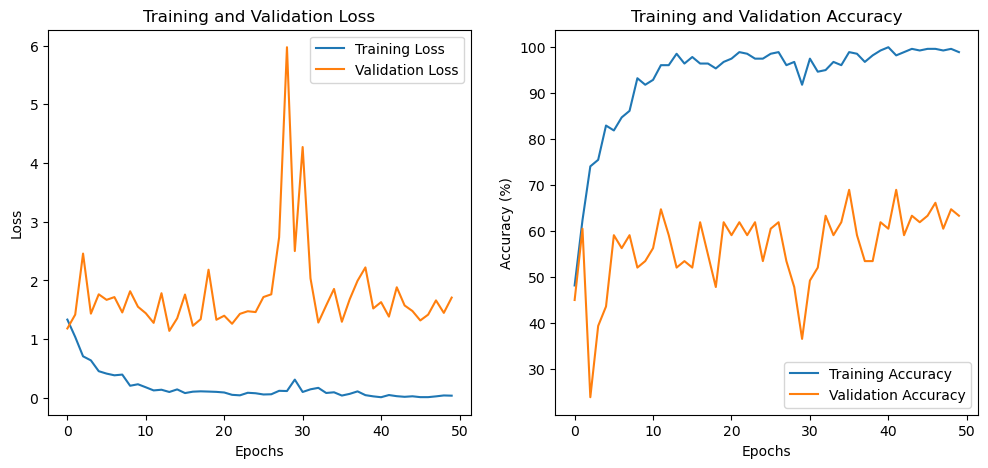

Training completed. Best model saved as best_model.pth
Model saved successfully!


In [52]:

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

# Save the fine-tuned model
torch.save(model.state_dict(), '5classes_finetuned_model.pth')
print("Model saved successfully!")


Training Set Confusion Matrix


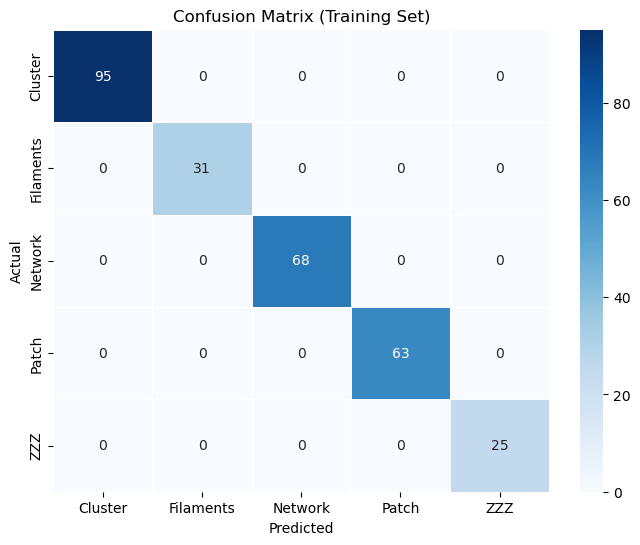

Validation Set Confusion Matrix


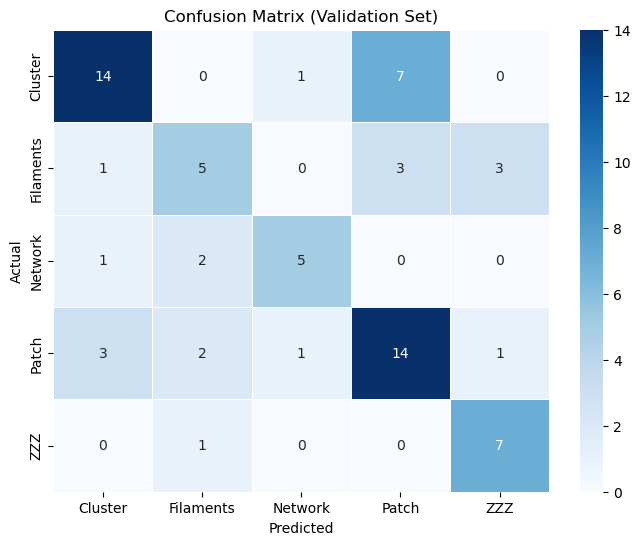

In [53]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(dataloader, dataset_name="Dataset"):
    """Compute confusion matrix for a given dataset."""
    true_labels = []
    pred_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    labels = list(dataset.label_to_index.keys())  # Get class names

    # Convert to DataFrame
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

# 🔹 **Compute and plot confusion matrices**
print("Training Set Confusion Matrix")
compute_confusion_matrix(train_loader, dataset_name="Training Set")

print("Validation Set Confusion Matrix")
compute_confusion_matrix(val_loader, dataset_name="Validation Set")


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CSV
data_csv = "selected_for_annotation_mt_strcture_20250310_MA.csv"
image_dir = "/mnt/d/lding/CLS/mousumiLiuDinner/set1to5_processed_results/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/GUV-MT_obj_png_selected_std15"
df = pd.read_csv(data_csv)
df = df.dropna(subset=["filename", "label"])
df["label"] = df["label"].astype(str)

# Split into Train (80%) & Validation (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Define Transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe.copy()
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(self.data["label"].unique()))}
        self.data["label"] = self.data["label"].map(self.label_to_index)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Datasets & DataLoaders
train_dataset = CustomDataset(train_df, image_dir, transform=train_transform)
val_dataset = CustomDataset(val_df, image_dir, transform=val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load EfficientNet-B0 Model & Modify for Classification
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),  # Add dropout to reduce overfitting
    nn.Linear(num_ftrs, len(train_dataset.label_to_index))
)
model = model.to(device)

# Define Focal Loss for better handling of class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=1, gamma=2)

# Use AdamW optimizer with weight decay for better generalization
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)

# Learning rate scheduler to adjust learning rate dynamically
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Training Loop with Early Stopping
num_epochs = 100
best_val_acc = 0
patience = 20
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    print(correct_train)
    print(total_train)
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct_train / total_train
    
    # Validation Step
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_val_loss / len(val_dataloader)
    val_acc = correct_val / total_val
    print(correct_val)
    print(total_val)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    scheduler.step()  # Adjust learning rate
    
    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Best Validation Accuracy:", best_val_acc)
            break


/home/ldin/anaconda3/envs/pytorch_cuda124/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldin/anaconda3/envs/pytorch_cuda124/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


111
282
8
71
Epoch 1: Train Loss = 0.8384, Train Acc = 0.3936, Val Loss = 1.1317, Val Acc = 0.1127
175
282
11
71
Epoch 2: Train Loss = 0.4016, Train Acc = 0.6206, Val Loss = 1.0631, Val Acc = 0.1549
206
282
28
71
Epoch 3: Train Loss = 0.2338, Train Acc = 0.7305, Val Loss = 0.6557, Val Acc = 0.3944
230
282
41
71
Epoch 4: Train Loss = 0.1187, Train Acc = 0.8156, Val Loss = 0.4889, Val Acc = 0.5775
241
282
46
71
Epoch 5: Train Loss = 0.0708, Train Acc = 0.8546, Val Loss = 0.3346, Val Acc = 0.6479
257
282
50
71
Epoch 6: Train Loss = 0.0385, Train Acc = 0.9113, Val Loss = 0.2482, Val Acc = 0.7042
259
282
51
71
Epoch 7: Train Loss = 0.0217, Train Acc = 0.9184, Val Loss = 0.2536, Val Acc = 0.7183
267
282
50
71
Epoch 8: Train Loss = 0.0201, Train Acc = 0.9468, Val Loss = 0.2469, Val Acc = 0.7042
270
282
49
71
Epoch 9: Train Loss = 0.0151, Train Acc = 0.9574, Val Loss = 0.2272, Val Acc = 0.6901
275
282
47
71
Epoch 10: Train Loss = 0.0082, Train Acc = 0.9752, Val Loss = 0.2250, Val Acc = 0.6620


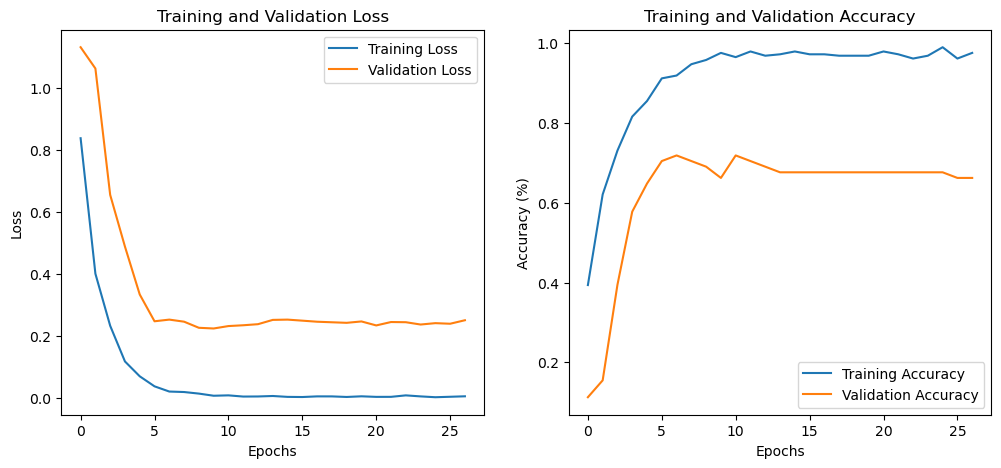

In [73]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


Training Set Confusion Matrix


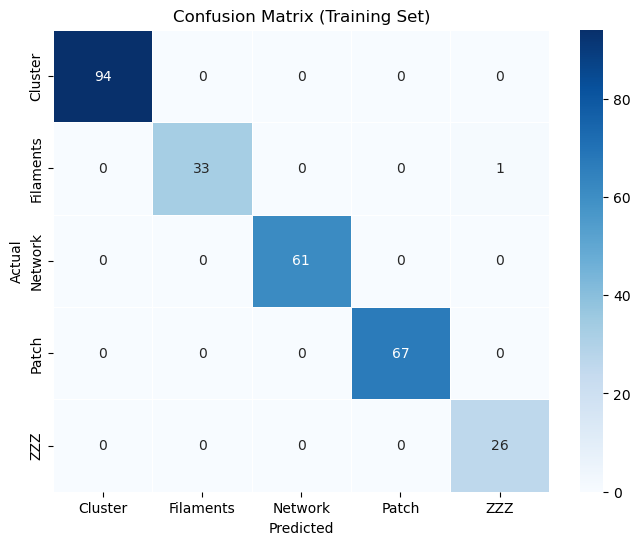

Validation Set Confusion Matrix


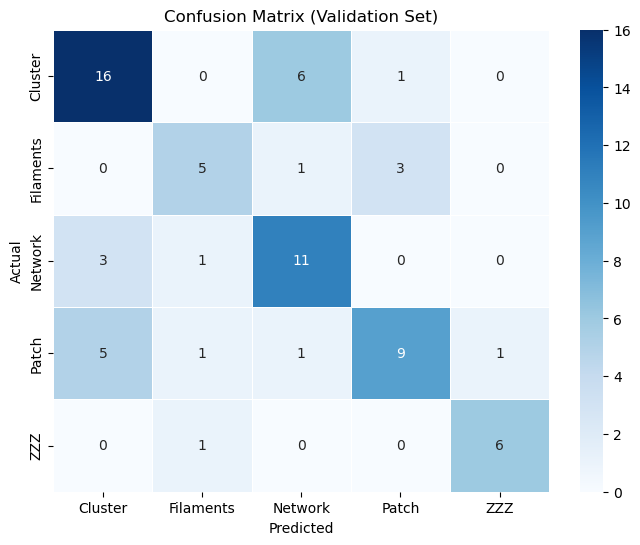

In [78]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(dataloader, dataset_name="Dataset"):
    """Compute confusion matrix for a given dataset."""
    true_labels = []
    pred_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    labels = list(dataset.label_to_index.keys())  # Get class names

    # Convert to DataFrame
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

# 🔹 **Compute and plot confusion matrices**
print("Training Set Confusion Matrix")
compute_confusion_matrix(train_dataloader, dataset_name="Training Set")

print("Validation Set Confusion Matrix")
compute_confusion_matrix(val_dataloader, dataset_name="Validation Set")

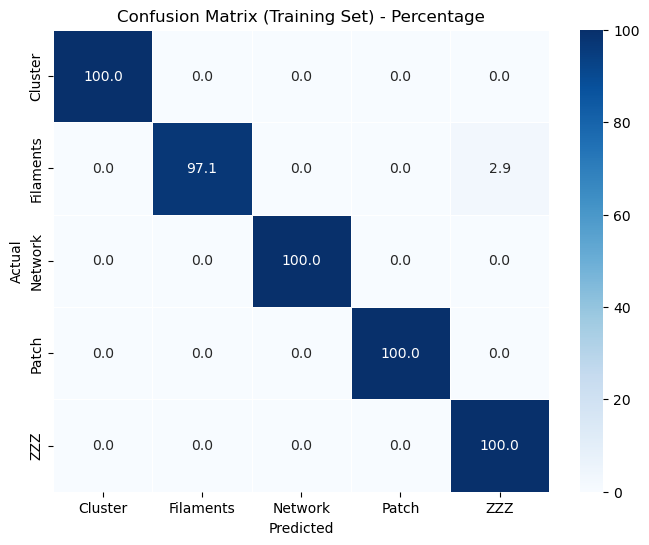

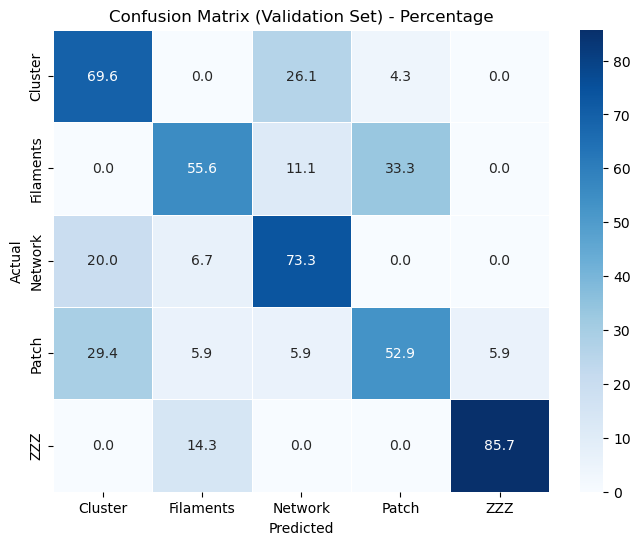

In [76]:
import numpy as np
# Function to evaluate model and plot confusion matrix with percentages
def evaluate_model(dataloader, dataset_name):
    true_labels, pred_labels = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages
    labels = list(train_dataset.label_to_index.keys())
    cm_df = pd.DataFrame(cm_percentage, index=labels, columns=labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt=".1f", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name}) - Percentage")
    plt.show()

evaluate_model(train_dataloader, "Training Set")
evaluate_model(val_dataloader, "Validation Set")

Training Set Confusion Matrix


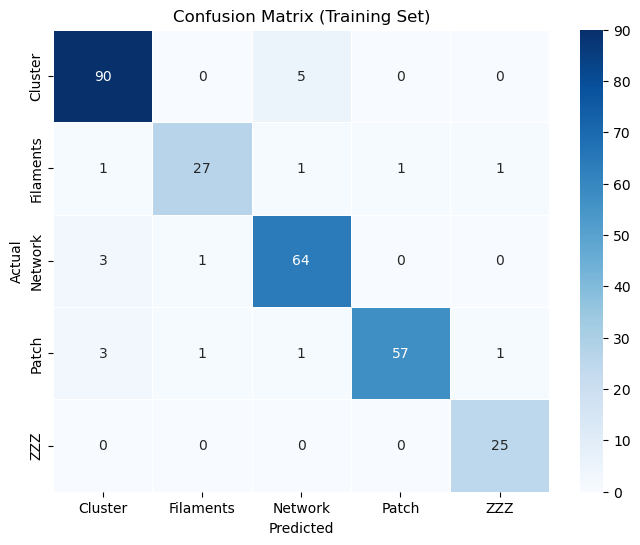

Validation Set Confusion Matrix


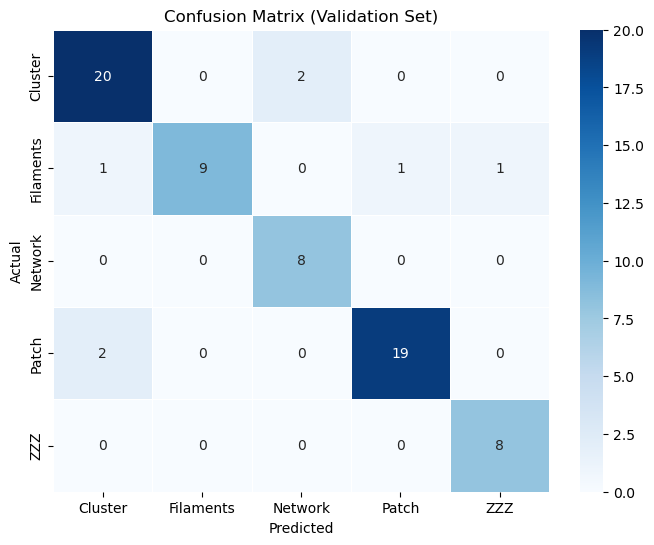

In [65]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(dataloader, dataset_name="Dataset"):
    """Compute confusion matrix for a given dataset."""
    true_labels = []
    pred_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    labels = list(dataset.label_to_index.keys())  # Get class names

    # Convert to DataFrame
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

# 🔹 **Compute and plot confusion matrices**
print("Training Set Confusion Matrix")
compute_confusion_matrix(train_loader, dataset_name="Training Set")

print("Validation Set Confusion Matrix")
compute_confusion_matrix(val_loader, dataset_name="Validation Set")